In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
import os
import re
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
df_train = pd.read_csv(path+'/train.csv')

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_train.shape

(159571, 8)

In [ ]:
test_samples = pd.read_csv(path+'/test.csv')
test_labels = pd.read_csv(path+'/test_labels.csv')
df_test = pd.merge(test_samples, test_labels, on="id")

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [ ]:
df_test.shape

(153164, 8)

In [ ]:
# removing sample with labels equal to -1
df_test = df_test.loc[df_test['toxic'] >= 0]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [ ]:
df_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
63974,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
63975,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
63976,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [ ]:
153164 - 63978

89186

In [ ]:
# 89186 values dropped !

In [ ]:
for label in df_train.columns[2:]:
    print(df_train[label].value_counts(), '\n')

0    144277
1     15294
Name: toxic, dtype: int64 

0    157976
1      1595
Name: severe_toxic, dtype: int64 

0    151122
1      8449
Name: obscene, dtype: int64 

0    159093
1       478
Name: threat, dtype: int64 

0    151694
1      7877
Name: insult, dtype: int64 

0    158166
1      1405
Name: identity_hate, dtype: int64 



In [ ]:
labels = df_train.columns[2:]
# Compute the class distribution for the train set
train_class_distribution = df_train.iloc[:, 2:].sum()

# Compute the class distribution for the test set
test_class_distribution = df_test.iloc[:, 2:].sum()

In [ ]:
train_class_distribution.sort_values(ascending = False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}

In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)

  # Replacing newline characters with spaces
  text = str(text).replace("\n", " ")

  # Removing any non-alphanumeric characters (except spaces)
  text = re.sub(r'[^\w\s]',' ',text)

  # Removing any numbers
  text = re.sub('[0-9]',"",text)

  # Removing any extra spaces
  text = re.sub(" +", " ", text)

  # Removing any non-ASCII characters
  text = re.sub("([^\x00-\x7F])+"," ",text)

  return text

In [ ]:
df2_train = df_train.copy()
df2_test = df_test.copy()
df2_train['comment_text']= df_train['comment_text'].apply(lambda x: clean_text(x))
df2_test['comment_text'] = df_test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [ ]:
# Initialize NLTK objects
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    preprocessed_text = " ".join(lemmatized_tokens)

    return preprocessed_text

# Apply the preprocessing function to the 'comment_text' column
df3_train['comment_text'] = df2_train['comment_text'].apply(preprocess_text)
df3_test['comment_text'] = df2_test['comment_text'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df3_train['comment_text'])

In [ ]:
# Convert text to sequences of integers (tokens)
list_tokenized_train = tokenizer.texts_to_sequences(df3_train['comment_text'].values)
list_tokenized_test = tokenizer.texts_to_sequences(df3_test['comment_text'].values)

In [ ]:
lengths = df3_train['comment_text'].str.split().apply(len)
percentile_98 = np.percentile(lengths, 98)
percentile_98

203.0

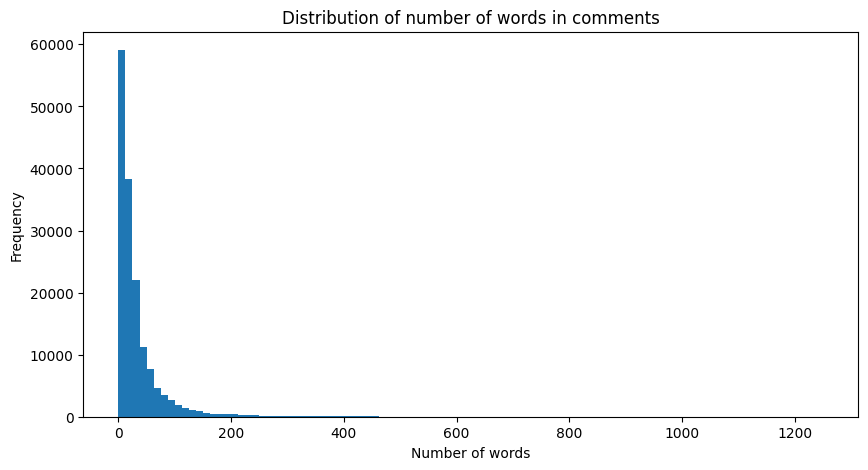

In [ ]:
import matplotlib.pyplot as plt

# Count the number of words in each comment
lengths = df3_train['comment_text'].str.split().apply(len)

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=100)
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of number of words in comments')
plt.show()

<h1>Padding Sequences</h1>

In [ ]:
max_length = 200

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=max_length, padding = 'post')
X_test  = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=max_length, padding = 'post')

In [ ]:
# Convert padded sequences to dataframes
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Concatenate the dataframes vertically
X = pd.concat([X_train_df, X_test_df], axis=0)

# Reset index
X.reset_index(drop=True, inplace=True)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,468,55,57,541,3878,9873,620,230,115,5500,...,0,0,0,0,0,0,0,0,0,0
1,13745,967,423,2568,3925,2356,24,4,812,100,...,0,0,0,0,0,0,0,0,0,0
2,292,298,61,153,17,164,239,1986,377,386,...,0,0,0,0,0,0,0,0,0,0
3,19,227,584,1246,5165,40,1991,396,2953,373,...,0,0,0,0,0,0,0,0,0,0
4,1437,2357,792,455,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177919,2749,38,2749,3098,13,719,18,4665,63,2334,...,0,0,0,0,0,0,0,0,0,0
177920,1038,405,2155,105,13,13,145,151491,1525,2155,...,0,0,0,0,0,0,0,0,0,0
177921,938,654,1161,547,1976,100,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177922,324,279,52,35,52,35,938,271,504,214,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train = df_train[df_train.columns[2:]].values
y_test = df_test[df_test.columns[2:]].values

In [ ]:
# Convert padded sequences to dataframes
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Concatenate the dataframes vertically
y = pd.concat([y_train_df, y_test_df], axis=0)

# Reset index
y.reset_index(drop=True, inplace=True)

In [ ]:
y

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
177919,1,0,1,0,0,0
177920,1,1,1,0,1,1
177921,1,0,1,0,1,0
177922,1,0,1,0,1,1


In [ ]:
X_train
print("Shape train set:", X_train.shape)

Shape train set: (159571, 200)


In [ ]:
X_test
print("Shape train set:", X_test.shape)

Shape train set: (18353, 200)


In [ ]:
y_train.shape

(159571, 6)

In [ ]:
y_test.shape

(18353, 6)

In [ ]:
print("Shape test set:", X_test.shape)

Shape test set: (18353, 200)


<h1>Dealing with Class Imbalances</h1>

Using the imbalanced-learn library. This library provides implementations of various resampling methods for handling class imbalance in machine learning datasets.

<h3>Using Random Oversampler</h3>

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.utils import resample

<h3>Manually Applying SMOTE</h3>

In [ ]:
X_train_resampled = []
y_train_resampled = []

for class_idx in range(len(y_train[0])):
    class_samples = [i for i, label in enumerate(y_train) if label[class_idx] == 1]
    X_class = X_train[class_samples]
    y_class = [y_train[i] for i in class_samples]

    X_resampled, y_resampled = resample(X_class, y_class, random_state=42)
    X_train_resampled.extend(X_resampled)
    y_train_resampled.extend(y_resampled)

In [ ]:
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)

<h1>Test, Train, Split</h1>



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [ ]:
X_train_final.shape

(73411, 200)

In [ ]:
y_train_final.shape

(73411, 6)

In [ ]:
X_test.shape

(18353, 200)

In [ ]:
y_test.shape

(18353, 6)

<h1>Model Training</h1>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='tanh', dropout = 0.2)))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
#model = Sequential()
#model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
#model.add(Bidirectional(LSTM(128, activation='tanh', dropout = 0.2)))
#model.add(Dense(6, activation='sigmoid'))  # 6 is the number of output classes (change as needed)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         20288640  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 20,553,350
Trainable params: 20,553,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

In [ ]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

220/220 [==============================] - 5s 8ms/step - loss: 0.1301 - accuracy: 0.7587
Test Loss: 0.1301, Test Accuracy: 0.7587


<h2>Updated Model</h2>

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(6, activation='sigmoid'))

In [ ]:
# Adding BatchNormalization to stabilize learning
model2.add(BatchNormalization())

In [ ]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Printing the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          20288640  
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 512)         788480    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                

In [ ]:
# Train the model
batch_size = 32

In [ ]:
history= model2.fit(X_train_final, y_train_final, batch_size=batch_size, epochs=3, validation_split=0.2)

Epoch 1/3
 710/1836 [==========>...................] - ETA: 2:25 - loss: 3.5572 - accuracy: 0.2024

KeyboardInterrupt: ignored

In [ ]:
# Evaluating the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

220/220 [==============================] - 4s 19ms/step - loss: 2.0147 - accuracy: 0.9658
Test Loss: 2.0147, Test Accuracy: 0.9658


In [ ]:
model2.save(path+'/baseline_smote.h5')

<h2>Gradio App!</h2>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# Load the pre-trained model and tokenizer
model_loaded = load_model(path+'/baseline_smote.h5')
import json

# Load the tokenizer from the JSON file
with open(path+'/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)

tokenizer = tokenizer_from_json(tokenizer_config)

# Define the labels for classification
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def classify_comment(comment):
    # Tokenize the comment and convert it into sequences
    comment_sequence = tokenizer.texts_to_sequences([comment])
    comment_sequence = tf.keras.preprocessing.sequence.pad_sequences(comment_sequence, maxlen=200)

    # Make predictions
    predictions = model_loaded.predict(comment_sequence)[0]
    results = dict(zip(labels, predictions))

    return results

In [ ]:
classify_comment('I will kill you!')

1/1 [==============================] - 0s 45ms/step


{'toxic': 0.10224342,
 'severe_toxic': -0.22798824,
 'obscene': 0.058418274,
 'threat': -0.422935,
 'insult': 0.0660854,
 'identity_hate': -0.2623558}

In [ ]:
def classify_comment_updated(comment, threshold=0.5):
    # Tokenize the comment and convert it into sequences
    comment_sequence = tokenizer.texts_to_sequences([comment])
    comment_sequence = tf.keras.preprocessing.sequence.pad_sequences(comment_sequence, maxlen=200)

    # Make predictions
    predictions = model_loaded.predict(comment_sequence)[0]

    # Apply threshold to obtain binary predictions
    binary_predictions = {label: (prob > threshold) for label, prob in zip(labels, predictions)}

    return binary_predictions

In [ ]:
classify_comment_updated('Fuck you!')

1/1 [==============================] - 0s 41ms/step


{'toxic': False,
 'severe_toxic': False,
 'obscene': False,
 'threat': False,
 'insult': False,
 'identity_hate': False}

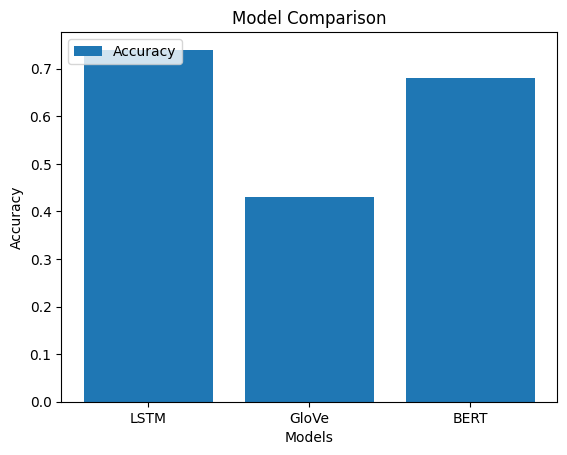

In [ ]:
import matplotlib.pyplot as plt

#Sample data (replace this with your actual data)
models = ['LSTM', 'GloVe', 'BERT']
accuracy_scores = [0.74, 0.43, 0.68]

#Create subplots for multiple graphs if needed
fig, ax1 = plt.subplots()

#Plot the accuracy scores on the left y-axis
ax1.bar(models, accuracy_scores, label='Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Models')
ax1.legend(loc='upper left')

#Title and show the plot
plt.title('Model Comparison')
plt.show()